## Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

The problem can be solved generally two ways:

**1. Regression**: if the interesting information for us if _how_ well will perform the student on the final exam (i.e. 1 to 10 scale) or what is the chance that the student will not pass on the final exam.

**2. Classification**: can be used if we want to setup classes, like grade (A, B, C etc.) or will/won't pass

In this particular case the goal is to select the student by whom the intervention is needed in order to pass on the final exam. The outcome should be binary (intervention needed / not needed), therefore I'll go for the classification.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features
# "passed" column is also included, so it needs to be deducted
n_features = student_data.shape[1]-1

# TODO: Calculate passing students
n_passed = student_data.loc[student_data["passed"]=="yes"].shape[0]

# TODO: Calculate failing students
n_failed = student_data.loc[student_data["passed"]=="no"].shape[0]

# TODO: Calculate graduation rate
grad_rate = (float(n_passed)/(n_passed + n_failed))*100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

X_all.head()
#y_all.head()

# Scaling the data
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_all = robust_scaler.fit_transform(X_all)

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300.

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify = y_all, test_size=(num_test/X_all.shape[0]), random_state=1)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. What are the general applications of each model? What are their strengths and weaknesses? Given what you know about the data, why did you choose these models to be applied?*

**Answer: **

**SVM**: 
 
Pro:
* Separates data using linear function (fast predictions)
* Maximalizes margin (helps to avoid overfitting)
* Using kernel trick (enriching data dimensions) it can solve highly complex issues (high number of features)

Con:
* Goodness is highly depending on the chosen kernel function (different datasets may need different kernel function)
* Sensitivity to noisy data

Applications:
* Bioinformatics (cancer classification, protein classification etc)
* Image classification
* Text categorization
* Control systems
* Environmental sciences (i.e. weather modelling)

Why:
* Fast prediction is one thing what we are looking for (cost)
* After preproccessing the data we have 48 features, which is relatively high
* For high variety of probelms it gives good resolution for the first shot, so it worth a try :)

**Ensemble**:

Pro:
* using random subsets of data (bagging) creating rules (weak learning), summing up the "subrules" we can create complex rules on dataset
* using these complex rules the error rate can be kept relatively low (no overfitting)
* high dimensional data can be handled quite well

Con:
* using too many rules, the training and prediction times might be too much

Applications:
* like by SVM, problems with high complexity

Why:
* the dataset has many features -> complexity is high, the classifier is might be good for solving this
* well generalized model can be trained

**Extra Tree**:

Pro:
* fast prediction
* using extremly randomization it performs better than a simple decision tree

Con:
* easy to overfit on given data -> not generalizing well enough
* ineffective to solve non-linear problems

Applications:
* physics: detection of particles
* molecular biology: amino acid sequence analysis
* control systems

Why:
* low need of preprocessing of data due that the model is using maximum information gain during rule selection
* many features are binary -> easily (linearly) separable
* fast prediction - low cost


### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    prediction_time = end - start
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(prediction_time)
    return [f1_score(target.values, y_pred, pos_label="yes"), prediction_time]


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    clf_name = clf.__class__.__name__
    train_len = len(X_train)
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    f1_train, train_time = predict_labels(clf, X_train, y_train)
    f1_test, test_time  = predict_labels(clf, X_test, y_test)
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(f1_train)
    print "F1 score for test set: {:.4f}.".format(f1_test)
    return [[clf_name,train_len,train_time,test_time,f1_train,f1_test]]

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [7]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
from sklearn import svm
# from sklearn import model_B
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
# from skearln import model_C
from sklearn.ensemble import ExtraTreesClassifier


# TODO: Initialize the three models
clf_A = svm.SVC(random_state = 1)
clf_B = BaggingClassifier(KNeighborsClassifier(), random_state = 1)
clf_C = ExtraTreesClassifier(random_state = 1)

# TODO: Set up the training set sizes
num_train = 100.
num_test = X_all.shape[0] - num_train
print "set has {} samples.".format(X_all.shape[0])
X_train_100, X_test_100, y_train_100, y_test_100 = train_test_split(X_all, y_all, test_size=(num_test/X_all.shape[0]), random_state=1)
print "Training set has {} samples.".format(X_train_100.shape[0])
print "Testing set has {} samples.".format(X_test_100.shape[0])
print "---------------------------------------"
num_train = 200.
num_test = X_all.shape[0] - num_train
X_train_200, X_test_200, y_train_200, y_test_200 = train_test_split(X_all, y_all, test_size=(num_test/X_all.shape[0]), random_state=1)
print "Training set has {} samples.".format(X_train_200.shape[0])
print "Testing set has {} samples.".format(X_test_200.shape[0])
print "---------------------------------------"

num_train = 300.
num_test = X_all.shape[0] - num_train
X_train_300, X_test_300, y_train_300, y_test_300 = train_test_split(X_all, y_all, test_size=(num_test/X_all.shape[0]), random_state=1)
print "Training set has {} samples.".format(X_train_300.shape[0])
print "Testing set has {} samples.".format(X_test_300.shape[0])
print "---------------------------------------"

# TODO: Execute the 'train_predict' function for each classifier and each training set size
col = ["Classifier","Training Set Size","Prediction Time (train)","Prediction Time (test)","F1 Score (train)","F1 Score (test)"]
results = pd.DataFrame(columns=col)
for clf in [clf_A, clf_B, clf_C]:
    res = train_predict(clf, X_train_100, y_train_100, X_test_100, y_test_100)
    results = results.append(pd.DataFrame(res, columns=col))
    print "---------------------------------------"
    res = train_predict(clf, X_train_200, y_train_200, X_test_200, y_test_200)
    results = results.append(pd.DataFrame(res, columns=col))
    print "---------------------------------------"
    res = train_predict(clf, X_train_300, y_train_300, X_test_300, y_test_300)
    results = results.append(pd.DataFrame(res, columns=col))
    print "---------------------------------------"

set has 395 samples.
Training set has 100 samples.
Testing set has 295 samples.
---------------------------------------
Training set has 200 samples.
Testing set has 195 samples.
---------------------------------------
Training set has 300 samples.
Testing set has 95 samples.
---------------------------------------
Training a SVC using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0010 seconds.
Made predictions in 0.0030 seconds.
F1 score for training set: 0.8609.
F1 score for test set: 0.8093.
---------------------------------------
Training a SVC using a training set size of 200. . .
Trained model in 0.0040 seconds
Made predictions in 0.0030 seconds.
Made predictions in 0.0030 seconds.
F1 score for training set: 0.8387.
F1 score for test set: 0.8243.
---------------------------------------
Training a SVC using a training set size of 300. . .
Trained model in 0.0090 seconds
Made predictions in 0.0060 seconds.
Made predictions in 0.0020 seconds.


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

In [8]:
from IPython.display import display
display(results)

,Classifier,Training Set Size,Prediction Time (train),Prediction Time (test),F1 Score (train),F1 Score (test)
0,SVC,100,0.001,0.003,0.860927,0.809322
0,SVC,200,0.003,0.003,0.838710,0.824281
0,SVC,300,0.006,0.002,0.829787,0.849673
0,BaggingClassifier,100,0.022,0.046,0.859155,0.747045
0,BaggingClassifier,200,0.046,0.067,0.838284,0.813333
0,BaggingClassifier,300,0.112,0.046,0.835267,0.780142
0,ExtraTreesClassifier,100,0.001,0.002,1.000000,0.707071
0,ExtraTreesClassifier,200,0.001,0.001,1.000000,0.748201
0,ExtraTreesClassifier,300,0.001,0.001,1.000000,0.686567


***Classifer 1 - SVC***

In [9]:
results[results.Classifier=="SVC"]

,Classifier,Training Set Size,Prediction Time (train),Prediction Time (test),F1 Score (train),F1 Score (test)
0,SVC,100,0.001,0.003,0.860927,0.809322
0,SVC,200,0.003,0.003,0.838710,0.824281
0,SVC,300,0.006,0.002,0.829787,0.849673


***Classifer 2 - Ensemble***

In [10]:
results[results.Classifier=="BaggingClassifier"]

,Classifier,Training Set Size,Prediction Time (train),Prediction Time (test),F1 Score (train),F1 Score (test)
0,BaggingClassifier,100,0.022,0.046,0.859155,0.747045
0,BaggingClassifier,200,0.046,0.067,0.838284,0.813333
0,BaggingClassifier,300,0.112,0.046,0.835267,0.780142


***Classifer 3 - ExtraTreesClassifier***

In [11]:
results[results.Classifier=="ExtraTreesClassifier"]

,Classifier,Training Set Size,Prediction Time (train),Prediction Time (test),F1 Score (train),F1 Score (test)
0,ExtraTreesClassifier,100,0.001,0.002,1,0.707071
0,ExtraTreesClassifier,200,0.001,0.001,1,0.748201
0,ExtraTreesClassifier,300,0.001,0.001,1,0.686567


## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Chosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

During the rating I'm going to consider the training set size, prediction time and F1 score on test set, since the goal is to predict the unseen data with the lowest cost and fastest way.


Using 100 samples to train the prediction time with SVC and decision tree classifiers were equally fast, though the F1 score is ~10% better in case of SVC. By decision tree it can be clearly seen that on the train the classifier overfitted (F1 score is 1) and on the test data it performes worse (0.7).

Using more samples samples (300) the decision tree classifier worsend a bit, ensemble classifier got a bit better, by SVC we can see gradual increase in F1 score compared to lower training sample trains. This was not the case by the other two classifiers.
The predicition time remained more or less the same as it was by 100 samples in case of classifier 1 and 3, by ensemble classifier it worsened a bit.

Generally we can see that the SVC classifier gives us a good generalization with low prediciton time. Decision classifier runs with similar speed, though it does not generalize well on the data, could not avoid the overfit of that model. Ensemble classifier runs with a magnitude of order slower speed, and though generalizes relatively well, the F1 score is not exceptional.

I would recommend SVC classifier since it is the most efficient predictor with given data.

Later on when more data will be available most probably the F1 score with SVM going to increase, though the training/prediction time going to increase.

Approximately by 100.000 datapoints I'd advise to change the model to a model which can handle more effectively bigger datasets like SGD classifier or kernel approximation.


### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. For example if you've chosen to use a decision tree or a support vector machine, how does the model go about making a prediction?*

**Answer: **

What support vector machine does is basically simple. It is trying to separate the data with a straight line/plane so, that distance (margin) between the line and the closest datapoints (support vectors) must be maximized. This gives us a solid result which has high chance to classify well unseen data.

<img src="http://dni-institute.in/blogs/wp-content/uploads/2015/09/SVM-Planes.png">

In case if the data cannot be separated with a single line, the machine is giving a "fake" dimension (based on a function which is called kernel) to the data in order to be able to make a straight separator plane. This is called kernel trick.
The function of kernel can be a custom made one, it depends on structure of the data what will be the best.

left pic. below - 2D data nonlinear separating plane 

right pic. below - 3D data linear separating plane

<img src="http://i.stack.imgur.com/1gvce.png">

In the case below the inner circle (blue points) clearly cannot be serparated with a line/plane. Using a cubic kernel function it is clear where can we separate the classes.

<img src="http://www.eric-kim.net/eric-kim-net/posts/1/imgs/data_2d_to_3d.png">


- Since we are maximizing the margin between the different classes of data, we can reach a well generalized model (giving unseen data to the model will highly likely to be still in the desired side of the line).

- With additional "fake" dimensions we can separate highly complex data (which are very difficult / impossible to describe with simple rules).

- "Fake" dimensions are enabling us to make very simple rules on data, which enabling us to make the prediction time very fast.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

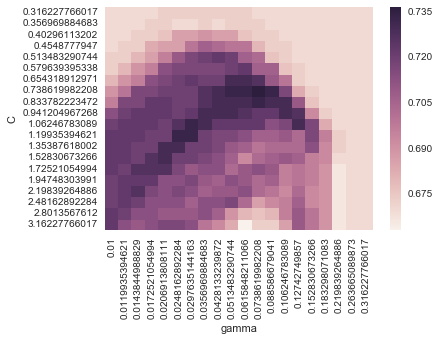

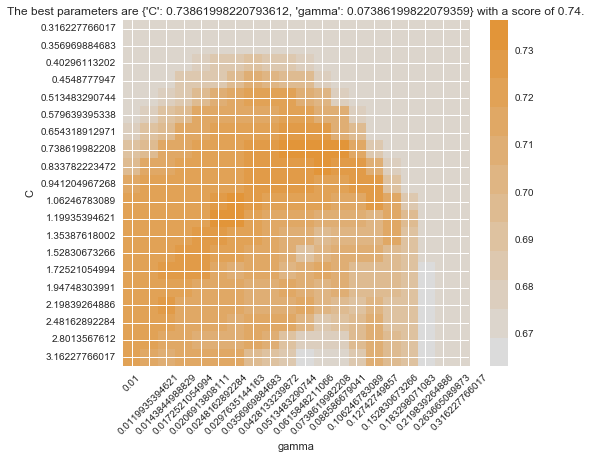

Made predictions in 0.0090 seconds.
Made predictions in 0.0030 seconds.
Tuned model has a training F1 score of 0.8777.
Tuned model has a testing F1 score of 0.7974.


In [13]:
# TODO: Import 'gridSearchCV' and 'make_scorer'
from sklearn import grid_search
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline  

def visual_gridsearch(model, X, y):
    from matplotlib import colors
    from matplotlib.colors import ListedColormap

    ddl_heat = ['#DBDBDB','#DCD5CC','#DCCEBE','#DDC8AF','#DEC2A0','#DEBB91',\
                '#DFB583','#DFAE74','#E0A865','#E1A256','#E19B48','#E29539']
    ddlheatmap = colors.ListedColormap(ddl_heat)
    C_range = np.logspace(-0.5, 0.5, num=20)
    gamma_range = np.logspace(-2, -0.5, num=20)
    param_grid = dict(gamma=gamma_range, C=C_range)
    grid = grid_search.GridSearchCV(model, param_grid=param_grid)
    grid.fit(X, y)
    
    # get scores and parameters in DataFrame format
    scores_pd = pd.DataFrame()
    for num in grid.grid_scores_:
        v = [v for _, v in num[0].iteritems()]
        v.append(num[1])
        columns = num[0].keys()
        columns.append("score")
        tmp = pd.DataFrame(v)
        tmp = tmp.T
        tmp.columns = columns
        scores_pd = scores_pd.append(tmp)
        #print num
    import seaborn as sns
    sns.heatmap(scores_pd.pivot("C","gamma","score"))
    
    # get scores in list
    scores = [x[1] for x in grid.grid_scores_]
    scores = np.array(scores).reshape(len(C_range), len(gamma_range))

    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=ddlheatmap)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title(
        "The best parameters are {} with a score of {:0.2f}.".format(
        grid.best_params_, grid.best_score_)
    )
    plt.show()
    return grid

grid_obj = visual_gridsearch(svm.SVC(), X_train, y_train)


# TODO: Create the parameters list you wish to tune
parameters = {
    'C':np.logspace(-1, 0.5, num=10),
    'gamma': np.logspace(-2, -1, num=10)
}

# TODO: Initialize the classifier
#clf = svm.SVC(kernel = 'rbf')

# TODO: Make an f1 scoring function using 'make_scorer' 
#f1_scorer = make_scorer(f1_score, pos_label="yes")

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
#grid_obj = grid_search.GridSearchCV(clf, parameters, scoring=f1_scorer,cv=2)

# TODO: Fit the grid search object to the training data and find the optimal parameters
#grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
f1_train,_ = predict_labels(clf, X_train, y_train)
f1_test,_ = predict_labels(clf, X_test, y_test)
print "Tuned model has a training F1 score of {:.4f}.".format(f1_train)
print "Tuned model has a testing F1 score of {:.4f}.".format(f1_test)

### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

Due low data availability (395 datapoints) the tuned model cannot perform much better. (same score as untuned)
Later on, when more data will be available most probably with correct tuning parameters the model can perform even better than the untuned one.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.